I only did spin-up for 1 year for methane, and I want to make sure that methane looks like aircore - what i might expect or if it really messed it up. 

First, going to check a single file called the following on ccycle:  

```
/oco2-data/tccon/analysis/jlaugh/Notebooks/TCCON/GGG2020-AICF/Data/aircores/v20201223/level2/Flight_20161018/launch1/AirCoreGMD007_201610181722_v20200103.txt
```

That you downloaded onto local and extracted relevant variables and converted to csv on 2/16/22. 

I uploaded that csv file to s3 and is stored in the same location on s3 as this notebook, ie do this 

```
aws s3 cp s3://geosfp-fullchem-20160601-20160605/AirCoreGMD007_201610181722_v20200103.txt . 
aws s3 cp s3://geosfp-fullchem-20160601-20160605/OutputDir/GEOSChem.SpeciesConc.20160601_0000z.nc4 .
```

In [29]:
import sys
import csv
import pandas as pd
import numpy as np
import pytz
import glob
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

FIRST, test how off the time is when you read it directly from UTC 


In [17]:
test = pd.read_csv('AC_GMD010_201807251658_R0.ict.csv')

In [ ]:
test.head()

In [ ]:
datetime.datetime.utcfromtimestamp(test['Mid_UTC'].values[0])

Yup, ver off. Need to use start time from the file. 

In [18]:
def converttodf(inputs):
    fieldnames = []
    for filename in inputs:
      with open(filename, "r", newline="") as f_in:
        reader = csv.reader(f_in)
        headers = next(reader)
        for h in headers:
          if h not in fieldnames:
            fieldnames.append(h)


    # # # Then copy the data
    with open("out.csv", "w", newline="") as f_out:   # Comment 2 below
      writer = csv.DictWriter(f_out, fieldnames=fieldnames)
      writer.writeheader()
      for filename in inputs:
        with open(filename, "r", newline="") as f_in:
          reader = csv.DictReader(f_in)  # Uses the field names in this file
          for line in reader:
            writer.writerow(line)

    df = pd.read_csv("out.csv")

    # insert NaN for -9999 values (be careful of lon values that are negative) 
    df.loc[:,:] < -99998 
    df_raw = df.where(~(df.loc[:,:] < -99998), other= np.NaN)
    
    complete_time_all_campaigns = []
    # insert completetime ..........................................
    for i,x in enumerate(inputs):
        
#         dateyr = x.split('AC_GMD007_')[1].rsplit('_')[0][0:4]
#         datemn = x.split('AC_GMD007_')[1].rsplit('_')[0][4:6]
#         datedy = x.split('AC_GMD007_')[1].rsplit('_')[0][6:8]
        dateyr = x.rsplit("_",2)[1].rsplit('_')[0][0:4]
        datemn = x.rsplit("_",2)[1].rsplit('_')[0][4:6]
        datedy = x.rsplit("_",2)[1].rsplit('_')[0][6:8]
        

        file_df = pd.read_csv(inputs[i])
        file_time_list = file_df['Mid_UTC'].tolist()
        
        
        # add completetime
        utc = pytz.UTC
        file_name_dtdelta = datetime.datetime(int(dateyr), int(datemn), int(datedy), 0, 0, 0)
        file_name_dtdelta = utc.localize(file_name_dtdelta)
        total_time = [datetime.timedelta(0,x)+file_name_dtdelta for x in file_time_list]
        complete_time_all_campaigns.append(total_time)

    complete_time_all_campaigns = np.concatenate(complete_time_all_campaigns).ravel()
    df_raw['completetime'] = complete_time_all_campaigns
    
    return df_raw

In [20]:
path = "/home/ubuntu/AC_GMD010_201807251658_R0.ict.csv"
inputs = sorted(glob.glob(path))
print(path)
print(inputs)

/home/ubuntu/AC_GMD010_201807251658_R0.ict.csv
['/home/ubuntu/AC_GMD010_201807251658_R0.ict.csv']


In [21]:
aircore_df = converttodf(inputs)

In [23]:
# https://stackoverflow.com/questions/35337299/python-datetime-to-float-with-millisecond-precision
res = [i.timestamp() for i in aircore_df['completetime']]

aircore_df['completetime'] = res

In [24]:
aircore_df.head()

,Mid_UTC,LAT,LON,P,GPS_ALT,CH4,CH4_unc,THETA,upper_alt_unc_lim_ch4,lower_alt_unc_lim_ch4,completetime
0,66693.62,36.69109,-97.41193,955.46,591.03,1993.96,1.58,309.79,75.06,76.83,1.532543e+09
1,66709.63,36.69100,-97.41190,953.46,601.99,1993.53,1.58,309.70,69.91,72.45,1.532544e+09
2,66723.90,36.69083,-97.41172,951.42,612.40,1993.38,1.58,309.78,98.48,122.53,1.532544e+09
3,66736.98,36.69067,-97.41178,949.30,624.67,1993.43,1.58,310.01,60.10,88.55,1.532544e+09
4,66749.56,36.69051,-97.41159,947.17,640.39,1993.42,1.58,309.99,119.27,110.15,1.532544e+09


In [26]:
# datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
datetime.datetime.utcfromtimestamp(aircore_df['completetime'].values[0])

datetime.datetime(2018, 7, 25, 18, 31, 33, 620000)

Double check the location

/home/ubuntu/miniconda/envs/geo/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/ubuntu/miniconda/envs/geo/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


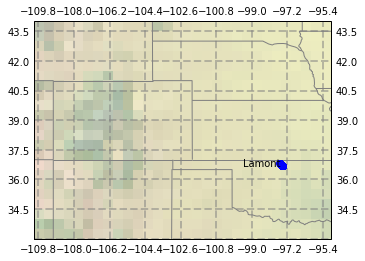

In [28]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-110, -95, 33, 44])

# Put a background image on for nice sea rendering.
ax.stock_img()
plt.plot(aircore_df.LON.values, aircore_df.LAT.values,
         color='blue', linewidth=2, marker='o',
         transform=ccrs.PlateCarree(),
         )


# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

plt.text(-97.56, 36.69, 'Lamont',
         horizontalalignment='right',
         transform=ccrs.Geodetic())
plt.show()

Now plot geos chem profile vs aircore data. Need to grab the data over lamont in geos chem. This is not interpolated to the profile, just in oklahoma. 

In [31]:
gcsim = xr.open_dataset('GEOSChem.SpeciesConc.20160601_0000z.nc4')

In [48]:
gcsim_methane = gcsim[['SpeciesConc_CH4','Met_PMID']]

In [49]:
gcsim_methanedf = gcsim_methane.to_dataframe().reset_index()

In [60]:
print(max(aircore_df.LON.values))
print(min(aircore_df.LON.values))
print(max(aircore_df.LAT.values))
print(min(aircore_df.LAT.values))

-97.41051
-97.60336
36.82178
36.68271


In [63]:
gcsim_methanedf.lon.unique()

array([-180., -175., -170., -165., -160., -155., -150., -145., -140.,
       -135., -130., -125., -120., -115., -110., -105., -100.,  -95.,
        -90.,  -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,
        -45.,  -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,
          0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,
        135.,  140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.])

In [64]:
gcsim_methanedf.lat.unique()

array([-89., -86., -82., -78., -74., -70., -66., -62., -58., -54., -50.,
       -46., -42., -38., -34., -30., -26., -22., -18., -14., -10.,  -6.,
        -2.,   2.,   6.,  10.,  14.,  18.,  22.,  26.,  30.,  34.,  38.,
        42.,  46.,  50.,  54.,  58.,  62.,  66.,  70.,  74.,  78.,  82.,
        86.,  89.])

In [72]:
gcsim_nearlamont = gcsim_methanedf.loc[(gcsim_methanedf['lon'] < -90.) & (gcsim_methanedf['lon'] > -100) & 
                                      (gcsim_methanedf['lat'] < 38) & (gcsim_methanedf['lat'] > 30)]

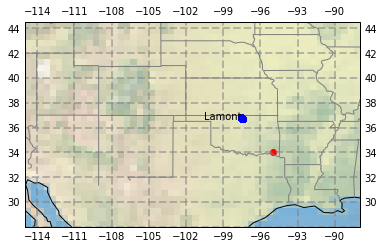

In [76]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-115, -88, 28, 44])

# Put a background image on for nice sea rendering.
ax.stock_img()
plt.plot(aircore_df.LON.values, aircore_df.LAT.values,
         color='blue', linewidth=2, marker='o',
         transform=ccrs.PlateCarree(),
         )

plt.scatter(gcsim_nearlamont.lon.values[::1000],gcsim_nearlamont.lat.values[::1000],
        color='red', marker='o',
        transform=ccrs.PlateCarree())
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

plt.text(-97.56, 36.69, 'Lamont',
         horizontalalignment='right',
         transform=ccrs.Geodetic())
plt.show()

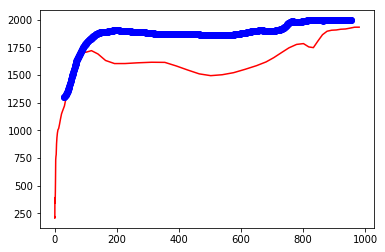

In [78]:
plt.plot(gcsim_nearlamont.Met_PMID.values, gcsim_nearlamont.SpeciesConc_CH4.values*1e9, color='red')
plt.plot(aircore_df.P.values, aircore_df.CH4.values,
         color='blue', linewidth=2, marker='o')

Background methane (from NOAA plot Ed Dlugokencky, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends_ch4/)) 

2018: 1850 ppb 
2016: 1830 ppb
2010: 1770 ppb

Even if I were to scale the initial values, the variability in the curve looks different? 